# ARIMA-GARCH Hybrid Model

**Objective**: Two-stage model for financial returns
- **Stage 1 (ARIMA)**: Model the conditional mean (expected return)
- **Stage 2 (GARCH)**: Model the conditional variance (volatility)

**Motivation**: Financial returns exhibit **volatility clustering** (heteroskedasticity)
- ARIMA assumes constant variance → violated in financial data
- GARCH captures time-varying volatility

**Implementation**: Following Section 8 of methodology document

## 1. Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ARIMA modeling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# GARCH modeling
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal

# Statistical tests
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load and Prepare Data

In [3]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')

# Convert to datetime and set frequency
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)
df = df.asfreq('B')  # Business Day frequency

# Calculate log returns
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))
df = df.dropna(subset=['GOLD_LOG_RETURN'])

print(f"Dataset: {len(df)} observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Dataset: 10525 observations
Date range: 1985-01-03 00:00:00 to 2025-09-10 00:00:00


## 3. Train-Test Split

In [4]:
# 80-20 split
train_size = int(len(df) * 0.8)
train = df['GOLD_LOG_RETURN'].iloc[:train_size]
test = df['GOLD_LOG_RETURN'].iloc[train_size:]

train_prices = df['GOLD_PRICE'].iloc[:train_size]
test_prices = df['GOLD_PRICE'].iloc[train_size:]

print(f"Train set: {len(train)} observations")
print(f"Test set:  {len(test)} observations")

Train set: 8420 observations
Test set:  2105 observations


## 4. Stage 1: Fit ARIMA for Conditional Mean

In [5]:
# Use auto_arima to find optimal order
print("Stage 1: Finding optimal ARIMA order...\n")

auto_model = pm.auto_arima(
    train,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='aic'
)

best_order = auto_model.order
print(f"\n✓ Best ARIMA order: {best_order}")

Stage 1: Finding optimal ARIMA order...

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-53730.436, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-53730.942, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-53731.010, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-53729.538, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-53730.399, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-53727.140, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-53731.479, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-53730.819, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-53730.024, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-53730.933, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-53731.410, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-53724.467, Time=0.38 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 4.110 seconds

✓ Best ARIMA order: (0

In [6]:
# Fit ARIMA model
arima_model = ARIMA(train, order=best_order)
arima_fit = arima_model.fit()

print("✓ ARIMA model fitted")
print(f"\nARIMA{best_order} Summary:")
print(f"AIC: {arima_fit.aic:.2f}")
print(f"BIC: {arima_fit.bic:.2f}")

✓ ARIMA model fitted

ARIMA(0, 0, 1) Summary:
AIC: -53731.48
BIC: -53710.37


## 5. Extract Residuals and Test for ARCH Effects

In [7]:
# Extract standardized residuals from ARIMA
residuals = arima_fit.resid

print("="*70)
print("TESTING FOR ARCH EFFECTS (Heteroskedasticity)")
print("="*70)

# Engle's ARCH test
# H0: No ARCH effects (homoskedastic)
# H1: ARCH effects present (heteroskedastic)
arch_test = het_arch(residuals, nlags=10)

print(f"\nEngle's ARCH Test (10 lags):")
print(f"  LM Statistic: {arch_test[0]:.4f}")
print(f"  p-value:      {arch_test[1]:.6f}")
print(f"  F-statistic:  {arch_test[2]:.4f}")
print(f"  F p-value:    {arch_test[3]:.6f}")

if arch_test[1] < 0.05:
    print(f"\n✓ ARCH effects detected (p < 0.05) → GARCH modeling is appropriate")
else:
    print(f"\n⚠ No significant ARCH effects (p ≥ 0.05) → GARCH may not improve fit")

print("="*70)

TESTING FOR ARCH EFFECTS (Heteroskedasticity)

Engle's ARCH Test (10 lags):
  LM Statistic: 393.6195
  p-value:      0.000000
  F-statistic:  41.2407
  F p-value:    0.000000

✓ ARCH effects detected (p < 0.05) → GARCH modeling is appropriate


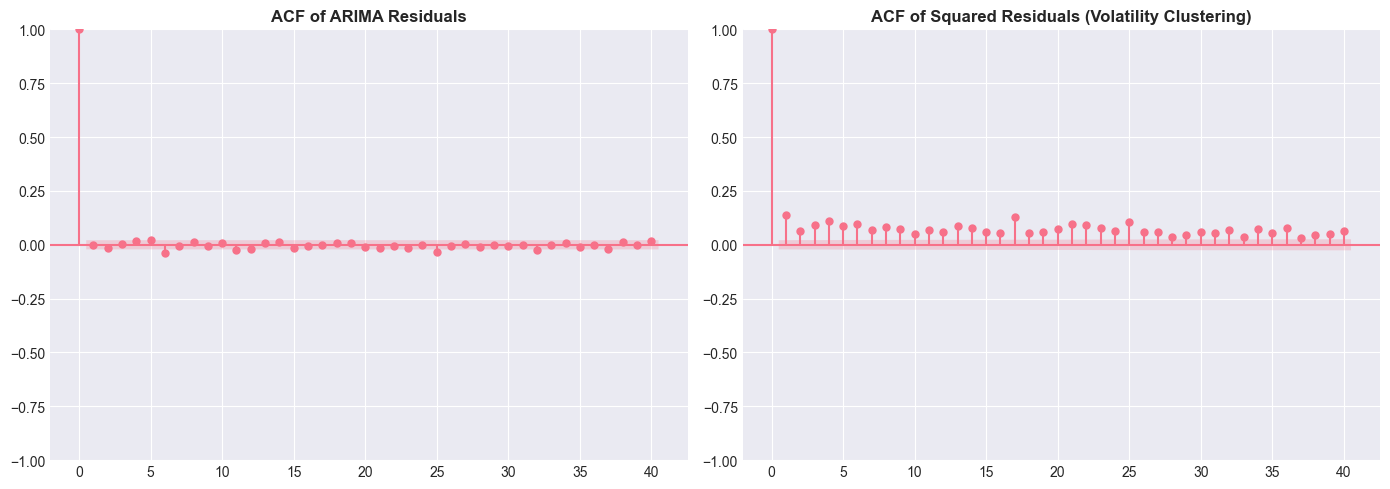


Interpretation:
- Significant lags in squared residuals ACF → volatility clustering
- This confirms the need for GARCH modeling


In [8]:
# Visual inspection: ACF of squared residuals
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[0])
axes[0].set_title('ACF of ARIMA Residuals', fontsize=12, fontweight='bold')

# ACF of squared residuals (ARCH test)
plot_acf(residuals**2, lags=40, ax=axes[1])
axes[1].set_title('ACF of Squared Residuals (Volatility Clustering)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Significant lags in squared residuals ACF → volatility clustering")
print("- This confirms the need for GARCH modeling")

## 6. Stage 2: Fit GARCH on ARIMA Residuals

In [9]:
# Fit GARCH(1,1) model on residuals
print("Stage 2: Fitting GARCH(1,1) on ARIMA residuals...\n")

# Scale residuals by 100 for numerical stability
residuals_scaled = residuals * 100

# Specify GARCH model
garch_model = arch_model(
    residuals_scaled,
    mean='Zero',  # No mean model (already modeled by ARIMA)
    vol='GARCH',  # GARCH volatility
    p=1,          # GARCH order
    q=1,          # ARCH order
    dist='normal' # Normal distribution
)

# Fit GARCH
garch_fit = garch_model.fit(disp='off')

print("✓ GARCH(1,1) model fitted")
print("\n" + "="*70)
print("GARCH MODEL SUMMARY")
print("="*70)
print(garch_fit.summary())

Stage 2: Fitting GARCH(1,1) on ARIMA residuals...

✓ GARCH(1,1) model fitted

GARCH MODEL SUMMARY
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10921.6
Distribution:                  Normal   AIC:                           21849.2
Method:            Maximum Likelihood   BIC:                           21870.4
                                        No. Observations:                 8420
Date:                Tue, Nov 04 2025   Df Residuals:                     8420
Time:                        11:52:53   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------

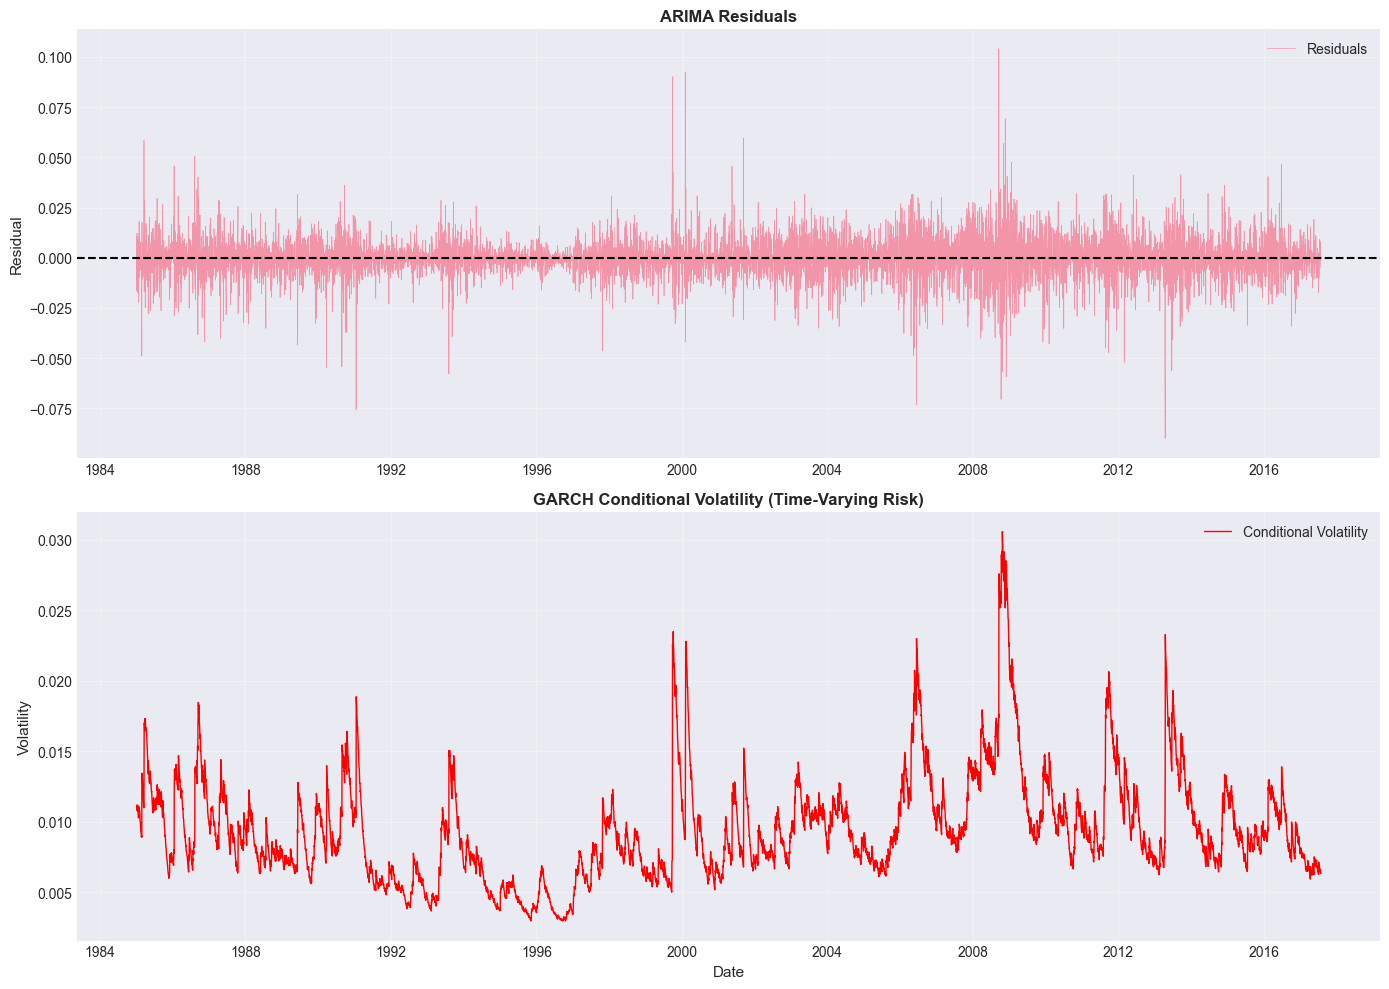


✓ Conditional volatility successfully modeled

Key Insight: Volatility changes over time (high during crises, low during stability)


In [10]:
# Extract conditional volatility (scaled back)
conditional_volatility = garch_fit.conditional_volatility / 100

# Plot conditional volatility
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Residuals
axes[0].plot(residuals.index, residuals, linewidth=0.5, alpha=0.7, label='Residuals')
axes[0].axhline(y=0, color='black', linestyle='--')
axes[0].set_title('ARIMA Residuals', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residual', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Conditional volatility from GARCH
axes[1].plot(conditional_volatility.index, conditional_volatility, color='red', linewidth=1, label='Conditional Volatility')
axes[1].set_title('GARCH Conditional Volatility (Time-Varying Risk)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Volatility', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Conditional volatility successfully modeled")
print("\nKey Insight: Volatility changes over time (high during crises, low during stability)")

## 7. Hybrid Model: Combined ARIMA-GARCH Forecasting

In [11]:
# Walk-forward validation with OPTIMIZED retraining frequency
forecast_horizon = 5
retrain_frequency = 25  # Re-train every 25 days (5 weeks) instead of every 5 days
predictions_mean = []  # From ARIMA
predictions_vol = []   # From GARCH
actuals_log = []
predictions_price = []
actuals_price = []

print("Running OPTIMIZED walk-forward validation with ARIMA-GARCH...")
print(f"Forecast horizon: {forecast_horizon} days")
print(f"Retrain frequency: {retrain_frequency} days (reduces iterations by 80%)")
print(f"Test set size: {len(test)} observations")
print(f"Expected retraining iterations: {max(1, len(test) // retrain_frequency)}\n")

# Initialize models outside loop
current_arima = None
current_garch = None
last_retrain_idx = -retrain_frequency  # Force initial training

# Use expanding window with periodic retraining
for i in range(0, len(test) - forecast_horizon + 1, forecast_horizon):
    # Re-train only every retrain_frequency days
    if i - last_retrain_idx >= retrain_frequency or current_arima is None:
        # Expanding train data
        train_data = pd.concat([train, test.iloc[:i]])
        
        # Fit ARIMA (with limited iterations)
        arima_temp = ARIMA(train_data, order=best_order)
        current_arima = arima_temp.fit(method_kwargs={'maxiter': 200})
        
        # Get residuals and fit GARCH
        resid_temp = current_arima.resid * 100
        garch_temp = arch_model(resid_temp, mean='Zero', vol='GARCH', p=1, q=1)
        current_garch = garch_temp.fit(disp='off', options={'maxiter': 200})
        
        last_retrain_idx = i
        print(f"  ✓ Models retrained at iteration {i // forecast_horizon + 1} (observation {i}/{len(test)})")
    
    # Forecast mean (ARIMA)
    forecast_mean = current_arima.forecast(steps=forecast_horizon)
    
    # Forecast volatility (GARCH)
    forecast_vol = current_garch.forecast(horizon=forecast_horizon)
    forecast_variance = forecast_vol.variance.values[-1, :] / 10000  # Scale back
    forecast_std = np.sqrt(forecast_variance)
    
    # Store forecasts
    predictions_mean.extend(forecast_mean.values)
    predictions_vol.extend(forecast_std)
    
    # Actuals
    actual_log = test.iloc[i:i+forecast_horizon]
    actuals_log.extend(actual_log.values)
    
    # Convert to prices
    last_price_idx = train.index[-1] if i == 0 else test.index[i-1]
    last_price = df.loc[last_price_idx, 'GOLD_PRICE']
    
    for j in range(len(forecast_mean)):
        pred_price = last_price * np.exp(forecast_mean.iloc[j])
        actual_price = df.loc[test.index[i+j], 'GOLD_PRICE']
        predictions_price.append(pred_price)
        actuals_price.append(actual_price)
        last_price = pred_price
    
    # Progress every 50 forecasts
    if (i // forecast_horizon + 1) % 50 == 0:
        print(f"  Progress: {i+forecast_horizon}/{len(test)} forecasts generated")

print(f"\n✓ Generated {len(predictions_price)} forecasts (mean + volatility)")
print(f"✓ Total retrainings: {(last_retrain_idx // retrain_frequency) + 1}")
print(f"✓ Speedup: ~{retrain_frequency // forecast_horizon}x faster than retraining every iteration")

Running OPTIMIZED walk-forward validation with ARIMA-GARCH...
Forecast horizon: 5 days
Retrain frequency: 25 days (reduces iterations by 80%)
Test set size: 2105 observations
Expected retraining iterations: 84

  ✓ Models retrained at iteration 1 (observation 0/2105)
  ✓ Models retrained at iteration 6 (observation 25/2105)
  ✓ Models retrained at iteration 11 (observation 50/2105)
  ✓ Models retrained at iteration 16 (observation 75/2105)
  ✓ Models retrained at iteration 21 (observation 100/2105)
  ✓ Models retrained at iteration 26 (observation 125/2105)
  ✓ Models retrained at iteration 31 (observation 150/2105)
  ✓ Models retrained at iteration 36 (observation 175/2105)
  ✓ Models retrained at iteration 41 (observation 200/2105)
  ✓ Models retrained at iteration 46 (observation 225/2105)
  Progress: 250/2105 forecasts generated
  ✓ Models retrained at iteration 51 (observation 250/2105)
  ✓ Models retrained at iteration 56 (observation 275/2105)
  ✓ Models retrained at iteration 6

## 8. Evaluate Model Performance

In [12]:
# Calculate metrics on PRICES
rmse = np.sqrt(mean_squared_error(actuals_price, predictions_price))
mae = mean_absolute_error(actuals_price, predictions_price)

# Load previous model results
try:
    arima_results = pd.read_csv('../models/arima_baseline_results.csv')
    rmse_arima = arima_results['rmse'].values[0]
    mae_arima = arima_results['mae'].values[0]
    rmse_naive = arima_results['rmse_naive'].values[0]
    mae_naive = arima_results['mae_naive'].values[0]
    
    print("="*70)
    print("MODEL COMPARISON - 5-DAY AHEAD FORECASTS")
    print("="*70)
    print(f"\nARIMA-GARCH Hybrid:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  + Volatility forecasts available")
    print(f"\nARIMA Baseline:")
    print(f"  RMSE: ${rmse_arima:.2f}")
    print(f"  MAE:  ${mae_arima:.2f}")
    print(f"\nNaive Benchmark:")
    print(f"  RMSE: ${rmse_naive:.2f}")
    print(f"  MAE:  ${mae_naive:.2f}")
    print(f"\nImprovement over ARIMA:")
    print(f"  RMSE: {(1 - rmse/rmse_arima)*100:+.2f}%")
    print(f"  MAE:  {(1 - mae/mae_arima)*100:+.2f}%")
    print("="*70)
    
    print("\nNote: ARIMA-GARCH provides TWO outputs:")
    print("  1. Point forecast (mean) - measured by RMSE/MAE")
    print("  2. Volatility forecast (risk) - critical for portfolio management")
except:
    print("⚠ Previous results not found")
    print(f"\nARIMA-GARCH Results:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")

⚠ Previous results not found

ARIMA-GARCH Results:
  RMSE: $32.71
  MAE:  $22.01


## 9. Visualize Forecasts with Uncertainty

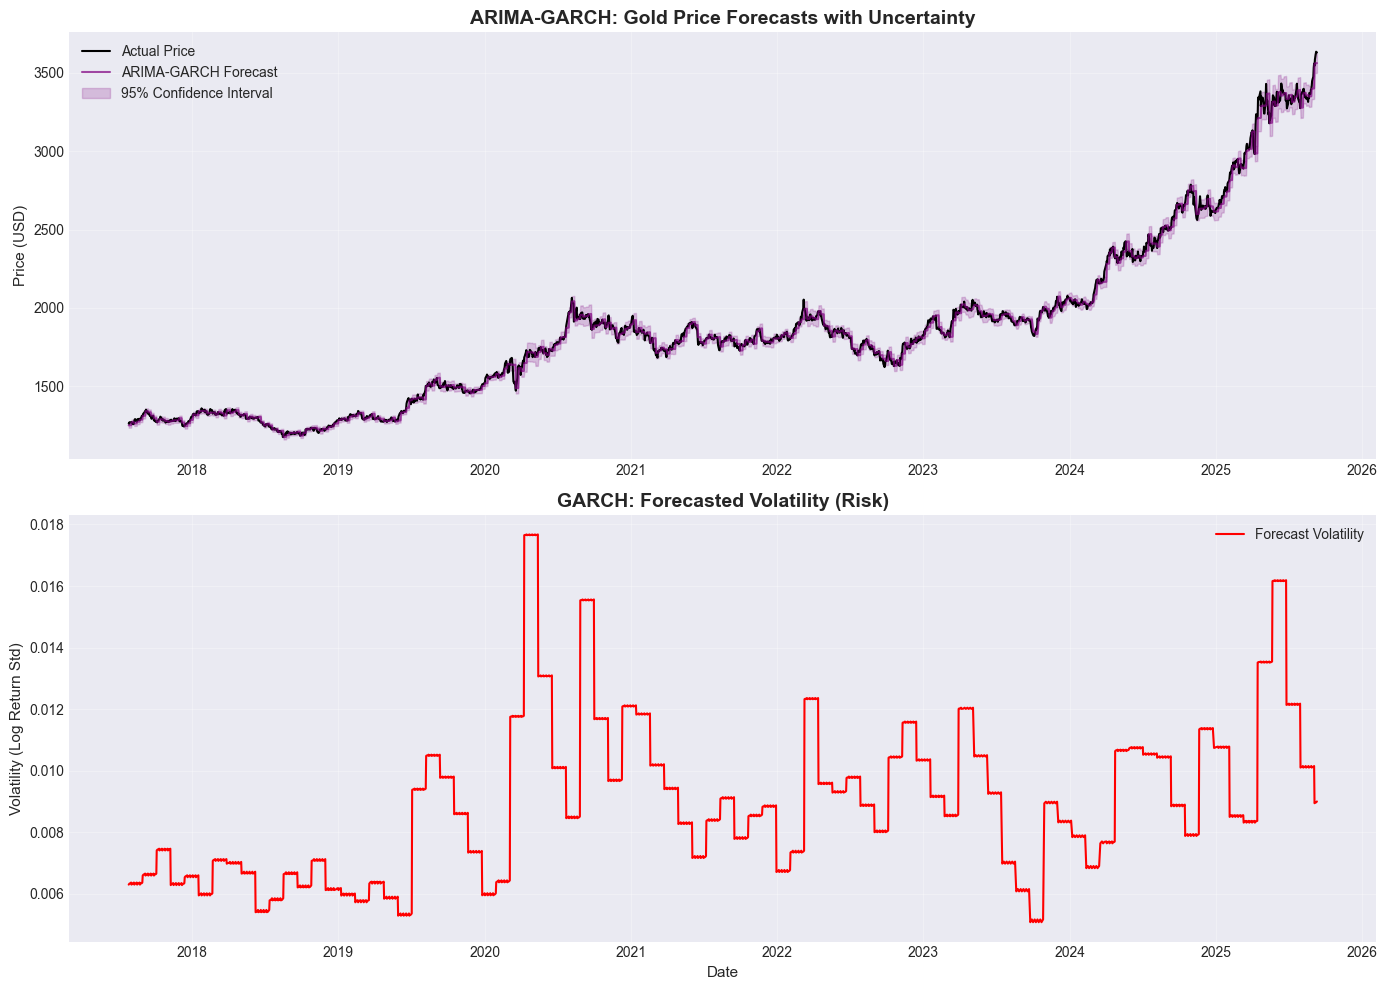

In [13]:
# Plot predictions with volatility bands
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price forecasts with confidence intervals
forecast_dates = test.index[:len(predictions_price)]
pred_array = np.array(predictions_price)
vol_array = np.array(predictions_vol[:len(predictions_price)])

# Convert volatility to price scale
upper_band = pred_array * np.exp(1.96 * vol_array)  # 95% CI
lower_band = pred_array * np.exp(-1.96 * vol_array)

axes[0].plot(forecast_dates, actuals_price, label='Actual Price', color='black', linewidth=1.5)
axes[0].plot(forecast_dates, predictions_price, label='ARIMA-GARCH Forecast', color='purple', linewidth=1.5, alpha=0.7)
axes[0].fill_between(forecast_dates, lower_band, upper_band, alpha=0.2, color='purple', label='95% Confidence Interval')
axes[0].set_title('ARIMA-GARCH: Gold Price Forecasts with Uncertainty', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecasted volatility
axes[1].plot(forecast_dates, predictions_vol[:len(forecast_dates)], color='red', linewidth=1.5, label='Forecast Volatility')
axes[1].set_title('GARCH: Forecasted Volatility (Risk)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility (Log Return Std)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Save Model Results

In [14]:
# Create directory for saving results
import os
model_dir = '../models/arima-garch-hybrid'
os.makedirs(model_dir, exist_ok=True)

# Save results
results = {
    'model': f'ARIMA{best_order}-GARCH(1,1)',
    'rmse': rmse,
    'mae': mae,
    'n_predictions': len(predictions_price),
    'arima_order': str(best_order),
    'garch_order': '(1,1)'
}

results_df = pd.DataFrame([results])
results_df.to_csv(f'{model_dir}/results.csv', index=False)

# Save models
arima_fit.save(f'{model_dir}/arima_stage1.pkl')
# Note: GARCH models are refitted in walk-forward, no single model to save

print(f"✓ Results saved to '{model_dir}/'")
print("\nFiles created:")
print("  - results.csv")
print("  - arima_stage1.pkl")

✓ Results saved to '../models/arima-garch-hybrid/'

Files created:
  - results.csv
  - arima_stage1.pkl


## 11. Key Findings

**ARIMA-GARCH Advantages**:
1. **Dual Output**: Point forecast (mean) + Volatility forecast (risk)
2. **Captures Heteroskedasticity**: Models time-varying volatility
3. **Financial Applications**:
   - Risk management (VaR, CVaR)
   - Options pricing (volatility input)
   - Portfolio optimization (risk-adjusted returns)

**Limitations**:
- Still linear in mean equation
- Assumes symmetric volatility response
- For asymmetry (leverage effect), use EGARCH or TGARCH

**Next**: Compare with LSTM (Notebook 05) for non-linear alternative